In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wednesday May 10 10:11:42 2023
Example Code for training an Image Deep Artifact Suppression network (FastDVDnet) for interactive MRI

Methods details in : 
HyperSLICE: HyperBand optimised Spiral for Low-latency Interactive Cardiac Examination, (2023)

Trained from flower image dataset.
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

@author: Dr. Olivier Jaubert
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import numpy as np
import tensorflow as tf
try:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('running on CPU')
import tensorflow_mri as tfmri
import random
import matplotlib.pyplot as plt
import datetime
import pathlib

# Local imports (works if you are in project folder)
import model.layers as layers
import utils.preprocessing_natural_images as preproc_filename_2_kspace
import utils.preprocessing_trajectory_gen as preproc_traj
import utils.preprocessing_fastdvdnet_noselect as preproc_fastdvdnet
import utils.preprocessing_rolling_fastdvdnet as preproc_roll
import utils.display_function_fastdvdnet as display_func

#Set seed for all packages
seed_value=1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
;

''

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [3]:
#Configuration
learning_rate=0.0001

config_traj=preproc_traj.config_optimized_traj()
config_preproc=preproc_fastdvdnet.config_base_preproc()
config_natural_images={'base_resolution':config_preproc['base_resolution'],'phases':config_preproc['phases'],'num_coils':10,'addmotion':1}

config={'experiment_path': 'Training_folder',
        'experiment_name': 'Test_FastDVDnet',
        'split' : [0.7,0.15,0.15], #train, val, test
        'split_mode': 'noshuffle', #noshuffle or random
        'learning_rate': learning_rate,
        'optimizer': tf.keras.optimizers.Adam(learning_rate=learning_rate,clipnorm=1),
        'epochs':200,
        'loss': tfmri.losses.StructuralSimilarityLoss(rank=2),
        'metrics':[tfmri.metrics.PeakSignalToNoiseRatio(rank=2),
                   tfmri.metrics.StructuralSimilarity(rank=2)]}

imshape=(config_preproc['phases'],config_preproc['base_resolution'],config_preproc['base_resolution'])

config_model={'scales': 3,
      'block_depth': 2,
      'base_filters': 32,
      'kernel_size': 3,
      'use_deconv': 'PixelShuffle',
      'rank': 2,
      'activation': tf.keras.activations.relu,
      'out_channels': 1,
      'kernel_initializer': tf.keras.initializers.HeUniform(seed=1),
      'time_distributed': False}

In [4]:
# Read files and split data 
train_files=[]
val_files=[]
test_files=[]
sorted_files=[x for x in sorted(list(map(str,data_dir.glob('roses/*'))))]
n=len(sorted_files); ntrain=int(config['split'][0]*n); nval=int(config['split'][1]*n); ntest=int(np.ceil(config['split'][2]*n))

train_files=sorted_files[:ntrain]
val_files=sorted_files[ntrain:ntrain+nval]
test_files=sorted_files[ntrain+nval:ntrain+nval+ntest]

# train_files=np.concatenate(train_files,axis=0)
# val_files=np.concatenate(val_files,axis=0)
# test_files=np.concatenate(test_files,axis=0)

# Shuffle files.
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

print('Total/Train/Val/Test:',len(train_files)+len(val_files)+len(test_files),
      '/',len(train_files),'/',len(val_files),'/',len(test_files),'leftovers:',n-ntrain-nval-ntest)

Total/Train/Val/Test: 641 / 448 / 96 / 97 leftovers: 0


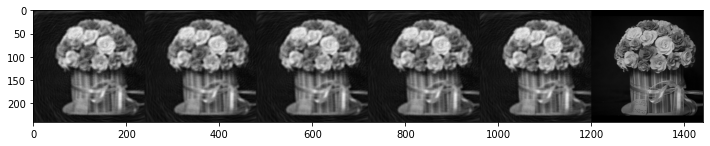

In [5]:
#Define Preprocessing run once to get input shapes
preproc_natural_image=preproc_filename_2_kspace.preprocessing_fn(**config_natural_images)
traj_function=preproc_traj.create_traj_fn(**config_traj)
preproc_function=preproc_fastdvdnet.preprocessing_fn(**config_preproc)
roll_function=preproc_roll.preprocessing_fn()
# Run Preprocessing once on case [0]
kspace=preproc_natural_image(train_files[1])
ds=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds)
for element in image:
  inputs_temp,gt_temp=preproc_function(element)
  inputs,gt=roll_function(inputs_temp,gt_temp)
plt.figure(figsize=(12,3))
plt.imshow(np.abs(np.concatenate((inputs[:,:,0],inputs[:,:,1],inputs[:,:,2],inputs[:,:,3],inputs[:,:,4],gt[:,:,0]),axis=1)),cmap='gray')

In [6]:
#Creating Tensorflow dataset
# Create datasets.
datasets=[train_files,val_files,test_files]
dataset_withtransforms=[]
for pp,dataset in enumerate(datasets):
    dataset = tf.data.Dataset.from_tensor_slices(
        tf.convert_to_tensor(list(map(str, dataset)), dtype=tf.string))
    #dataset =tf.data.Dataset.from_tensor_slices(list(map(str, dataset))).filter(lambda x: tf.strings.regex_full_match(x,'.*png'))
    dataset=dataset.map(preproc_natural_image,num_parallel_calls=1)
    dataset = dataset.apply(traj_function)
    dataset=dataset.map(preproc_function,num_parallel_calls=1)
    if pp==0:
        dataset=dataset.cache()
    dataset=dataset.map(roll_function,num_parallel_calls=1)
    dataset=dataset.shuffle(buffer_size=8,seed=1)
    if pp>0:
        dataset=dataset.cache()
    dataset=dataset.batch(1,drop_remainder=True)
    dataset=dataset.prefetch(buffer_size=-1)
    dataset_withtransforms.append(dataset)

In [7]:
#Defining Paths
path = config['experiment_path']
exp_name = os.path.splitext(os.path.basename(config['experiment_name']))[0]
exp_name += '_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = os.path.join(path, exp_name)

#Define and compile Model
image_inputs= tf.keras.Input(inputs.shape)
outputs=layers.FastDVDNet(**config_model)(image_inputs)
model=tf.keras.Model(inputs=image_inputs,outputs=outputs)

model.compile(optimizer=config['optimizer'],
                    loss=config['loss'],
                    metrics=config['metrics'] or None,
                    run_eagerly=False)

model.summary()
callbacks=[]
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_weights_only=False,
        save_best_only=True))
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=os.path.join(exp_dir,'logs')))
display_fn=display_func.display_fn(complex_part='abs',selected_image=-1)
callbacks.append(tfmri.callbacks.TensorBoardImages(log_dir=os.path.join(exp_dir,'logs'),
     max_images=2,x= dataset_withtransforms[1],display_fn=display_fn))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 5)]     0         
                                                                 
 fast_dvd_net (FastDVDNet)   (None, 240, 240, 1)       1589506   
                                                                 
Total params: 1,589,506
Trainable params: 1,589,506
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(dataset_withtransforms[0],
          epochs=config['epochs'],
          verbose=1,
          callbacks=callbacks,
          validation_data=dataset_withtransforms[1])

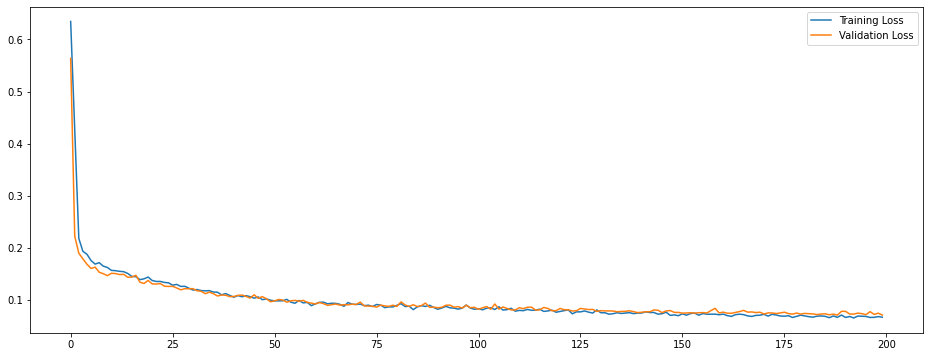

In [ ]:
fig = plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
leg = plt.legend()



In [ ]:
#Save Configuration
import json
global_config={**config,**config_traj,**config_preproc,**config_model}
for key in global_config.keys():
    global_config[key]=str(global_config[key])
filename = os.path.join(exp_dir,'config.json')
with open(filename, 'w') as f:
    f.write(json.dumps(global_config))


In [ ]:
#Evaluate On Test Set
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
model.load_weights(checkpoint_filepath)
result = model.evaluate(dataset_withtransforms[2])
results_dict=dict(zip(model.metrics_names, result))
filename = os.path.join(exp_dir,'results.json')
with open(filename, 'w') as f:
    f.write(json.dumps(results_dict))

2023-05-31 14:07:06.165127: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model: FAILED_PRECONDITION: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


97/97 [==============================] - 24s 224ms/step - loss: 0.0701 - psnr: 30.9771 - ssim: 0.9299


Text(0.5, 1.0, 'Six consecutive frames with change: Top Input, Mid GT, Bottom Recon')

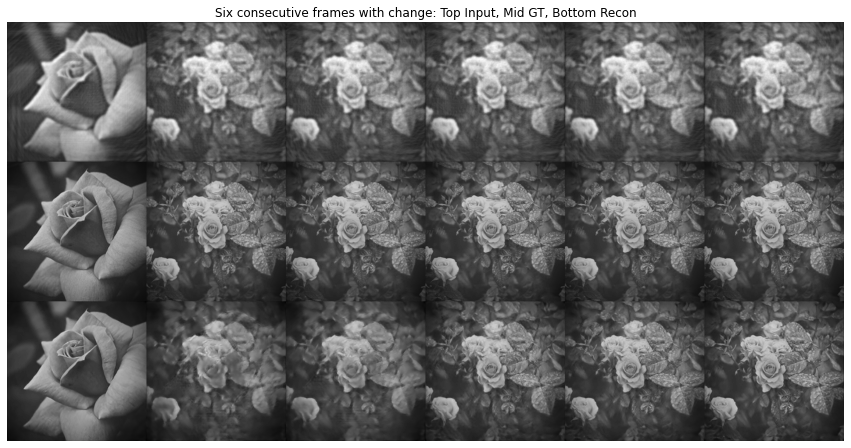

In [ ]:
#Inference
#Preproc series 1
kspace=preproc_natural_image(test_files[0])
ds=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds)
for element in image:
  inputs_temp,gt_temp=preproc_function(element)
#Preproc series 2
kspace2=preproc_natural_image(test_files[2])
ds2=tf.data.Dataset.from_tensors(kspace2)
image2=traj_function(ds2)
for element in image2:
  inputs_temp2,gt_temp2=preproc_function(element)

#Run model on buffered 5 image in a series
inputs=np.concatenate((inputs_temp,inputs_temp2),axis=2)
gts=np.concatenate((gt_temp,gt_temp2),axis=2)
buffer=[]
output=[]
for pp in range(inputs.shape[-1]):
  buffer.append(inputs[:,:,pp])
  if pp>3:
    model_input=np.expand_dims(np.stack(buffer,axis=-1),axis=0)
    output.append(model(model_input))
    buffer=buffer[1:]

output=np.concatenate(output,axis=-1)
plot_image=np.concatenate((inputs[:,:,4:],gts[:,:,4:],output[0,...]),axis=0)

plt.figure(figsize=(15,12))
start_frame=7
plt.imshow(np.abs(np.concatenate((plot_image[:,:,start_frame],plot_image[:,:,start_frame+1],plot_image[:,:,start_frame+2],plot_image[:,:,start_frame+3],plot_image[:,:,start_frame+4],plot_image[:,:,start_frame+5]),axis=1)),cmap='gray')
plt.axis('off')
plt.title('Six consecutive frames with change: Top Input, Mid GT, Bottom Recon')

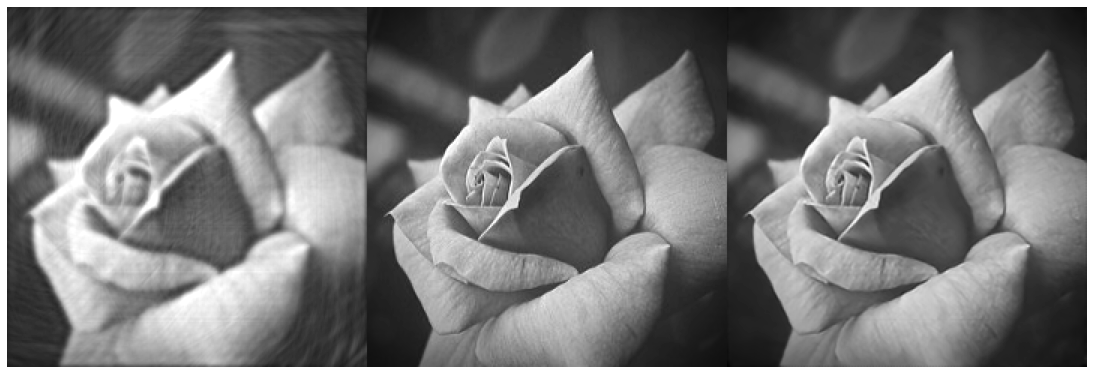

In [ ]:
#From Left to Right: Input, Ground Truth, Reconstructed.
savepath=os.path.join(exp_dir,'video_orientation_change')
display_func.plotVid(np.transpose(plot_image,axes=[1,0,2]),interval=55,savepath=savepath)